## Libraries

In [2]:
import os
import time

import polars as pl
import pandas as pd
import duckdb

# import pyspark
# from pyspark.sql import SparkSession

#Might add ibis vaex

import seaborn as sns
import matplotlib.pyplot as plt


## Raw Files [Path]

In [3]:
raw_main_data = r'Data_extracted\creditcard.csv'

## File reading

In [4]:
def read_files(path: str, reader: str) -> dict:
    finalTime = None
    df = None
    if reader  == 'duckDB':
        global con_duck
        startTime = time.time()

        con_duck = duckdb.connect(database = ":memory:")

        con_duck.execute('CREATE TABLE creditcard AS FROM read_csv_auto("Data_extracted\creditcard.csv")')
        df = con_duck.execute("SELECT * FROM creditcard").fetchdf()

        endTime = time.time()

    elif reader  == 'pandas':
        startTime = time.time()
        df = pd.read_csv(path)
        endTime = time.time()
    elif reader  == 'polars':
        startTime = time.time()
        df = pl.read_csv(path, ignore_errors=True)
        endTime = time.time()

    finalTime = endTime - startTime
    assert len(df) > 0
    
    return {
            'reader':reader,
            'reading_time': finalTime,
            'data': df
            }

def data_populating(df, reader: str, register_multipliyer: int) -> dict:
    finalTime = None
    df_concated = None
    if reader == 'duckDB':

        startTime = time.time()
        con_duck.register("my_data", df)
        for _ in range(1,register_multipliyer):
            con_duck.execute("INSERT INTO creditcard SELECT * FROM my_data")
            
        df_concated = con_duck.execute("SELECT * FROM creditcard").fetchdf()

        endTime = time.time()

    elif reader == 'pandas':
        startTime = time.time()
        df_concated = pd.concat([df]* register_multipliyer, ignore_index=True)
        endTime = time.time()

    elif reader == 'polars':
        startTime = time.time()

        df_concated = pl.concat([df] * register_multipliyer)

        endTime = time.time()

    
    finalTime = endTime - startTime

    assert len(df_concated) == register_multipliyer*len(df)
    
    return {
            'reader':reader,
            'reading_time': finalTime,
            'data' : df_concated
            }

def data_grouping(data, reader: str, grouping_columns: list, agg_columns: list) -> dict:
    finalTime = None
    df_concated = None
    if reader == 'duckDB':

        startTime = time.time()
            
        df_grouped = con_duck.execute("SELECT * FROM creditcard").fetchdf()

        endTime = time.time()

    elif reader == 'pandas':
        startTime = time.time()
        df_grouped = data.groupby(by=[grouping_columns])[agg_columns].sum()
        endTime = time.time()

    elif reader == 'polars':

        agg_exprs = [pl.col(col).sum() for col in agg_columns]
        
        startTime = time.time()

        df_grouped = data.group_by(grouping_columns).agg(agg_exprs)

        endTime = time.time()

    
    finalTime = endTime - startTime

    return {
            'reader':reader,
            'reading_time': finalTime,
            'data' : df_concated
            }

def format_to_parquet(df, reader: str, saving_path: str):
    finalTime = None
    if 'duckDB':
        startTime = time.time()
        df.to_parquet()
        endTime = time.time()
    elif 'pandas':
        df.to_arrow(f'{saving_path}_polars.parquet')
    elif 'polars':
        df.write_parquet(f'{saving_path}_polars.parquet')
    
    finalTime = endTime - startTime

    return {
            'reader':reader,
            'reading_time': finalTime,
            }

In [16]:
test = pl.read_csv('Data_extracted/creditcard.csv', infer_schema=False).select(['Class','Amount'])

In [ ]:
agg_exprs = [pl.col(col).sum() for col in test['Amount']]

test.group_by(['Class']).agg(agg_exprs)
test

AttributeError: 'Series' object has no attribute 'columns'

## Reading Speed

In [4]:
readers = ['polars','pandas','duckDB']
reading_results = {}

for reader in readers:
    reading_results[reader] = read_files(path = raw_main_data, reader = reader)

graph_results = {}
for reader in readers:
    graph_results[reader] = reading_results[reader]["reading_time"]
    print(f'{reader}: {reading_results[reader]["reading_time"]}') 

polars: 0.1835169792175293
pandas: 1.2530531883239746
duckDB: 0.6130874156951904


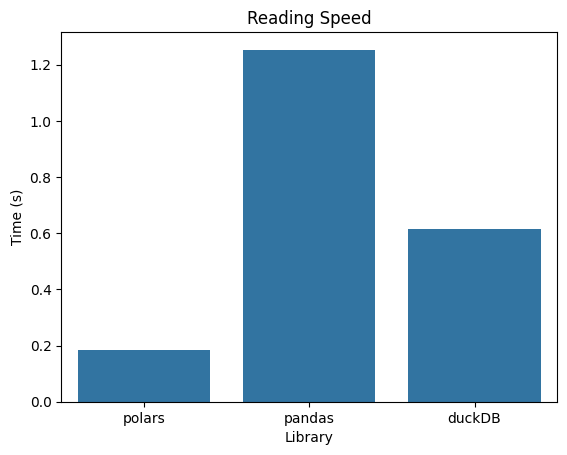

In [16]:
sns.barplot(x=list(graph_results.keys()),y=list(graph_results.values()))

plt.title('Reading Speed')
plt.xlabel('Library')
plt.ylabel('Time (s)')
plt.show()

## Register Increment Speed

In [18]:
increment_results = {}

for reader in readers:
    increment_results[reader] = data_populating(df = reading_results[reader]["data"], reader = reader, register_multipliyer = 5)

graph_results = {}
for reader in readers:
    graph_results[reader] = increment_results[reader]["reading_time"]
    print(f'{reader}: {increment_results[reader]["reading_time"]}') 
    print(f'{reader}: {len(increment_results[reader]["data"])}') 


polars: 0.008165121078491211
polars: 1424035
pandas: 0.1342945098876953
pandas: 1424035
duckDB: 1.1042563915252686
duckDB: 1424035


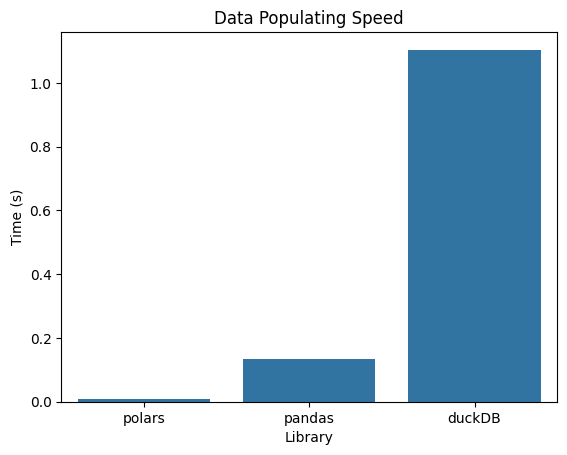

In [20]:
sns.barplot(x=list(graph_results.keys()),y=list(graph_results.values()))

plt.title('Data Populating Speed')
plt.xlabel('Library')
plt.ylabel('Time (s)')
plt.show()

## Data Grouping Speed

In [ ]:
grouping_results = {}

for reader in readers:
    grouping_results[reader] = data_populating(df = increment_results[reader]["data"], reader = reader, register_multipliyer = 5)

graph_results = {}
for reader in readers:
    graph_results[reader] = grouping_results[reader]["reading_time"]
    print(f'{reader}: {grouping_results[reader]["reading_time"]}') 
    print(f'{reader}: {len(grouping_results[reader]["data"])}') 

## Data Filtering Speed

## Column Sorting Speed

## Memory Usage

## Data Offload Speed